In [5]:
import pygmt
import numpy as np
import pandas as pd
import re
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors as colours
import os
import requests
import geopandas as gpd
import shapely
import json
import cartopy.crs as ccrs

from aussedthickrf.utils import get_australian_sedimentary_basins


In [4]:
gdf = get_australian_sedimentary_basins()

In [3]:
fig = pygmt.Figure()
fig_width = 15
with fig.subplot(nrows=2, ncols=1, figsize=(f"{fig_width}c", f"3c")):
    with fig.set_panel(0):
        region=[112, 155, -46, -8]
        ln_min, ln_max, lt_min, lt_max = region
        projection = f"M{int(np.mean([ln_min, ln_max]))}/{int(np.mean([lt_min, lt_max]))}/{fig_width}c"
        fig.basemap(region=region, projection=projection, frame=True)
        for i, polygon in gdf[::-1].iterrows():  # [::-1] flips the df to plot the oldest first
            # pygmt doesn't seem to have a nice way of colouring polygons
            # from a GeoDataFrame using a column to map to colours
            # so loop through and select the fill
            # Have to wrap each polygon into its own GeoDataFrame
            df = gpd.GeoDataFrame([polygon])
            fill = df["fill"].iloc[0]
            fig.plot(data=df, region=region, projection=projection, fill=fill, transparency=25)
        fig.coast(
            region=region,
            projection=projection,
            shorelines=1,
            resolution="i",
            water="#e6ffff",
            borders="2/1p,grey",
        )
    
    with fig.set_panel(1):
        region = [0, fig_width, 0, 1]
        projection = f"X{fig_width}c/1c"
        fig.basemap(region=region, projection=projection, frame=["wsne"])
        max_age = max([v["hasBeginning"] for v in periods.values()])

        def _scale_age_to_bar_length(age):
            return age / max_age * fig_width

        for i, p in enumerate(periods.values()):
            # fill = colours.to_hex(cmap(i))
            fill = p["fill"]
            beginning = _scale_age_to_bar_length(p["hasBeginning"])
            end = _scale_age_to_bar_length(p["hasEnd"])
            fig.plot(x=beginning, y=0.5, style=f"B1c+b{end}", fill=fill, region=region, projection=projection)

        font = "10p,Helvetica"
        for k, e in eras.items():
            beginning = _scale_age_to_bar_length(e["hasBeginning"])
            end = _scale_age_to_bar_length(e["hasEnd"])
            mid = (end + beginning) / 2
            length = beginning - end
            angle = 0
            fig.plot(x=end, y=0.4, style="v0.3c+bt+et+a80", direction=([angle], [length]), pen="1p", region=region, projection=projection)
            fig.text(x=mid, y=0.6, font=font, text=k, region=region, projection=projection)

fig.show()

NameError: name 'gdf' is not defined

In [7]:
delays = pd.read_csv("/Users/auggiemarignier/Documents/ANU/aus_sediment_thickness/AusSedThickRF/data/processed/20230421_140018/delays.txt", names=("Network", "Station", "Longitude", "Latitude", "TPsb"), sep="\s+")
delays.set_index("Station", inplace=True)
points = [shapely.Point([st["Longitude"], st["Latitude"]]) for _, st in delays.iterrows()]
delays["geometry"] = points
delays = gpd.GeoDataFrame(delays)

In [10]:
station_age = []
for i, point in delays.iterrows():
    contains = gdf.contains(point.geometry)
    if contains.any():
        basins = gdf[contains]
        oldest = basins["period_age"].idxmax()
        station_age.append(basins.loc[oldest]["period"])
    else:
        station_age.append(None)
delays["Period"] = station_age

In [11]:
delays.head()

,Network,Longitude,Latitude,TPsb,geometry,Period
Station,,,,,,
BM31,OA,129.993058,-22.995938,0.0,POINT (129.99306 -22.99594),None
BN29,OA,130.496421,-22.006397,0.0,POINT (130.49642 -22.00640),None
BO24,OA,130.997155,-19.507225,0.0,POINT (130.99715 -19.50722),Cambrian
BV23,OA,134.479800,-19.018600,0.0,POINT (134.47980 -19.01860),Precambrian
BV30,OA,134.462000,-22.494000,0.0,POINT (134.46200 -22.49400),None


In [1]:
from aussedthickrf.utils import get_geological_timeline

In [2]:
geological_timeline = get_geological_timeline()

In [3]:
periods = {}
for k, v in geological_timeline.items():
    if v["type"] == "period":
        if v["parent"][0] in ["Cenozoic", "Mesozoic", "Paleozoic"]:
            periods[k] = v

In [6]:
for k, v in periods.items():
    rgb = colours.to_rgb(v["fill"])
    r, g, b = tuple(int(i * 255) for i in rgb)
    print(f"{int(v['hasEnd'])} {r} {g} {b} {int(v['hasBeginning'])} {r} {g} {b}; {k}")

0 249 249 127 2 249 249 127; Quaternary
2 255 219 75 23 255 219 75; Neogene
23 255 167 111 66 255 167 111; Paleogene
66 130 204 115 145 130 204 115; Cretaceous
145 26 196 236 201 26 196 236; Jurassic
201 130 79 168 251 130 79 168; Triassic
251 249 95 68 298 249 95 68; Permian
298 95 182 181 358 95 182 181; Carboniferous
358 213 156 88 419 213 156 88; Devonian
419 175 227 205 443 175 227 205; Silurian
443 0 175 144 485 0 175 144; Ordovician
485 131 175 119 541 131 175 119; Cambrian


In [12]:
with open("/Users/auggiemarignier/Documents/ANU/aus_sediment_thickness/AusSedThickRF/data/geological_timescale/geological_timeline.cpt", "w") as f:
    for k, v in periods.items():
        rgb = colours.to_rgb(v["fill"])
        r, g, b = tuple(int(i * 255) for i in rgb)
        f.write(
            f"{int(v['hasEnd'])} {r} {g} {b} {int(v['hasBeginning'])} {r} {g} {b}; {k}\n"
        )


In [13]:
fig = pygmt.Figure()
fig_width = 15
region = [0, fig_width, 0, 1]
projection = f"X{fig_width}c/1c"
fig.colorbar(region=region, projection=projection, cmap="/Users/auggiemarignier/Documents/ANU/aus_sediment_thickness/AusSedThickRF/data/geological_timescale/geological_timeline.cpt")

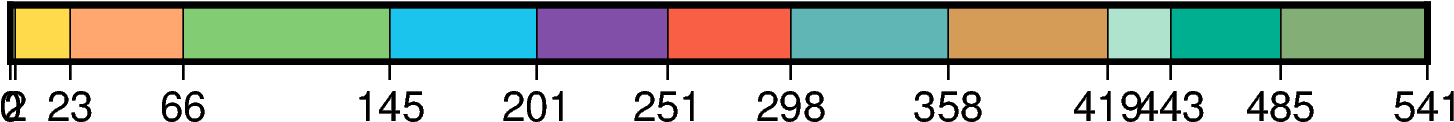

In [14]:
fig.show()